In [1]:
# 1. Setup và Config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import xgboost as xgb

RANDOM_STATE = 42
N_JOBS = -1

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_on_logscale(pred_log, y_log_true):
    rmse_log = np.sqrt(mean_squared_error(y_log_true, pred_log))
    pred = np.expm1(pred_log); true = np.expm1(y_log_true)
    return {
        "rmse_log": rmse_log,
        "rmse": rmse(true, pred),
        "r2_log": r2_score(y_log_true, pred_log)
    }


In [3]:
# 2. Load dữ liệu
train = pd.read_csv("house-prices-data/train.csv")
test  = pd.read_csv("house-prices-data/test.csv")
print(train.shape, test.shape)
display(train.head(5))


(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# 3. Tổng quan và missing
display(train.dtypes.value_counts())
na = train.isnull().sum().sort_values(ascending=False)
display(na[na>0].head(20))

object     43
int64      35
float64     4
Name: count, dtype: int64

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageCond        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

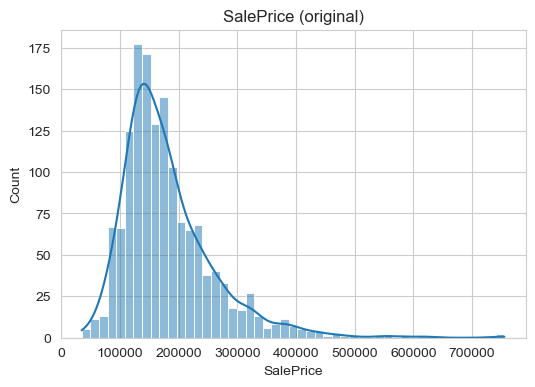

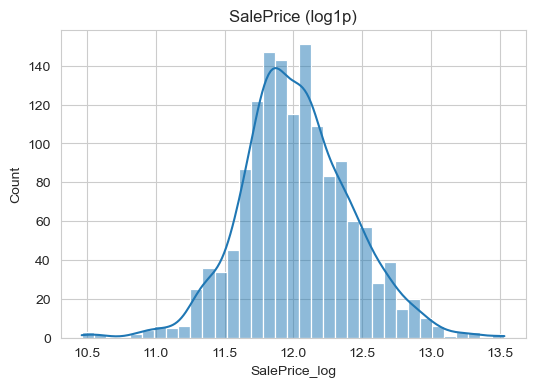

In [4]:
# 4. Target distribution + log1p
fig = plt.figure(figsize=(6,4))
sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice (original)")
plt.show()

train["SalePrice_log"] = np.log1p(train["SalePrice"])
fig = plt.figure(figsize=(6,4))
sns.histplot(train["SalePrice_log"], kde=True)
plt.title("SalePrice (log1p)")
plt.show()


Top 10 numeric tương quan mạnh nhất:


SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
Name: SalePrice, dtype: float64


Top 10 categorical tương quan mạnh nhất (sau target encoding):


Neighborhood    0.726538
ExterQual       0.686927
BsmtQual        0.681198
KitchenQual     0.675440
GarageFinish    0.553058
FireplaceQu     0.532365
Foundation      0.504074
GarageType      0.495873
BsmtFinType1    0.458613
HeatingQC       0.441290
Name: SalePrice, dtype: float64

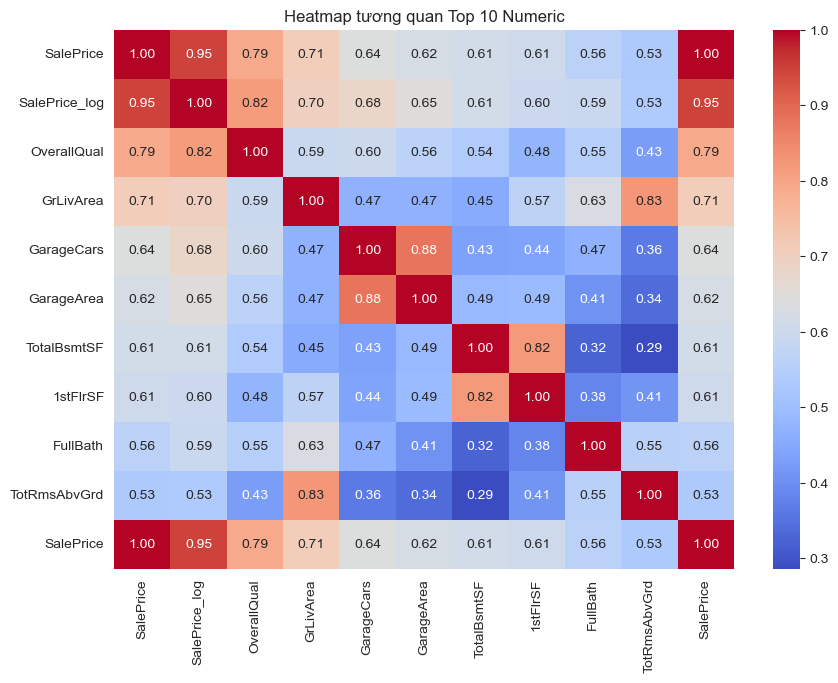

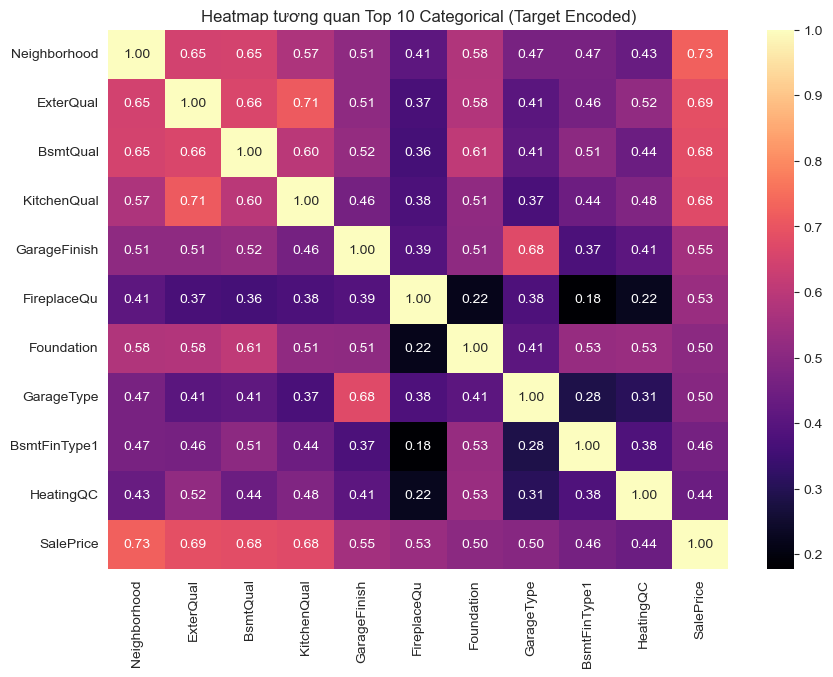

In [ ]:
#5
from category_encoders.target_encoder import TargetEncoder

# Lấy danh sách cột numeric & categorical
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()

# 2. Target Encoding cho categorical
encoder = TargetEncoder(cols=cat_cols)
train_cat_enc = encoder.fit_transform(train[cat_cols], train["SalePrice"])

# 3. Gộp numeric + categorical đã mã hóa
corr_data = pd.concat([train[num_cols], train_cat_enc], axis=1)

# 4. Tính ma trận tương quan với SalePrice
corr_all = corr_data.corr()["SalePrice"].sort_values(ascending=False)

# Lấy top 10 numeric + top 10 categorical mạnh nhất
top_num_corr = corr_all[corr_all.index.isin(num_cols)].head(10)
top_cat_corr = corr_all[corr_all.index.isin(cat_cols)].head(10)

print("Top 10 numeric tương quan mạnh nhất:")
display(top_num_corr)

print("\nTop 10 categorical tương quan mạnh nhất (sau target encoding):")
display(top_cat_corr)

# 5.1 Heatmap cho Top 10 Numeric
num_features = list(top_num_corr.index) + ["SalePrice"]
corr_num_matrix = corr_data[num_features].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_num_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap tương quan Top 10 Numeric")
plt.show()

# 5.2 Heatmap cho Top 10 Categorical (Encoded)
cat_features = list(top_cat_corr.index) + ["SalePrice"]
corr_cat_matrix = corr_data[cat_features].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_cat_matrix, annot=True, cmap="magma", fmt=".2f")
plt.title("Heatmap tương quan Top 10 Categorical (Target Encoded)")
plt.show()



Top 10 feature numeric tương quan mạnh nhất với SalePrice:


Index(['SalePrice_log', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

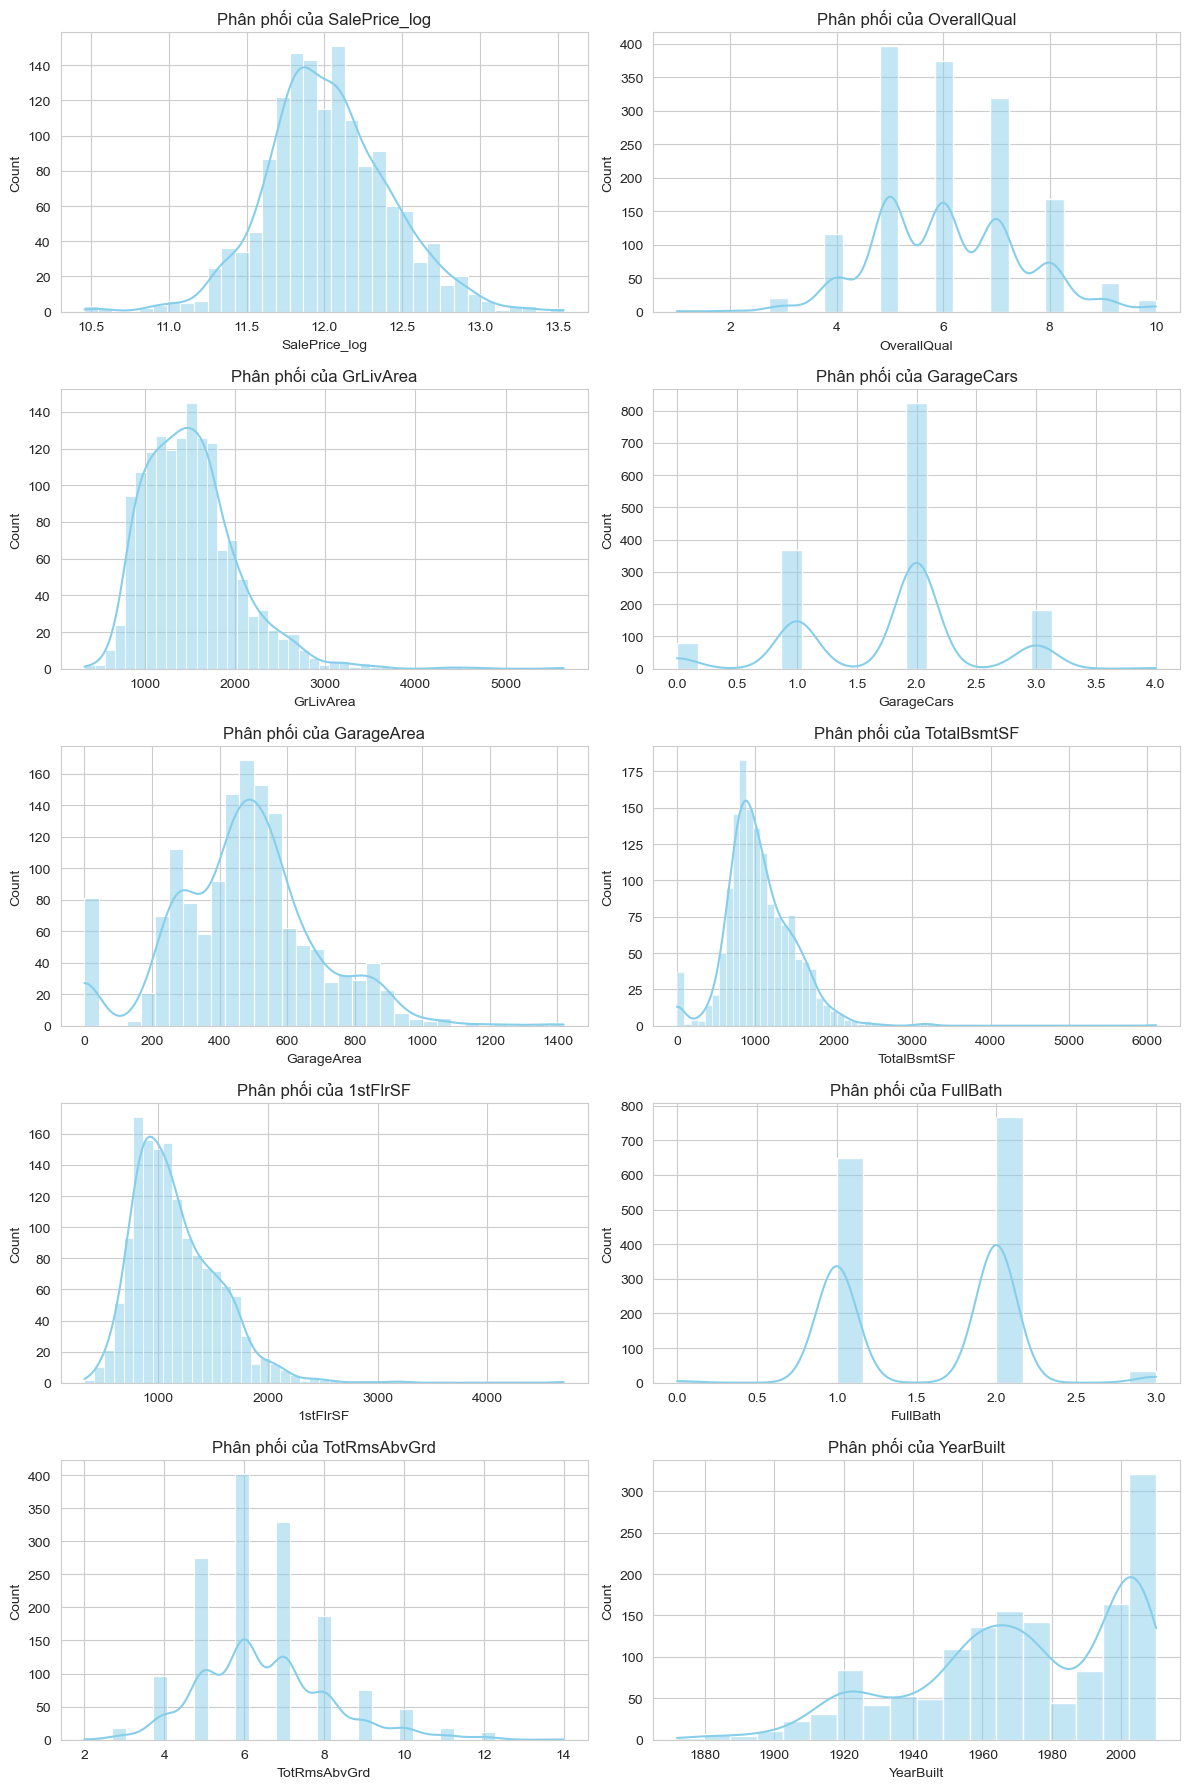

Top 10 biến phân loại có ít giá trị duy nhất nhất:


['Street',
 'Alley',
 'CentralAir',
 'Utilities',
 'MasVnrType',
 'LandSlope',
 'PoolQC',
 'PavedDrive',
 'GarageFinish',
 'BsmtQual']

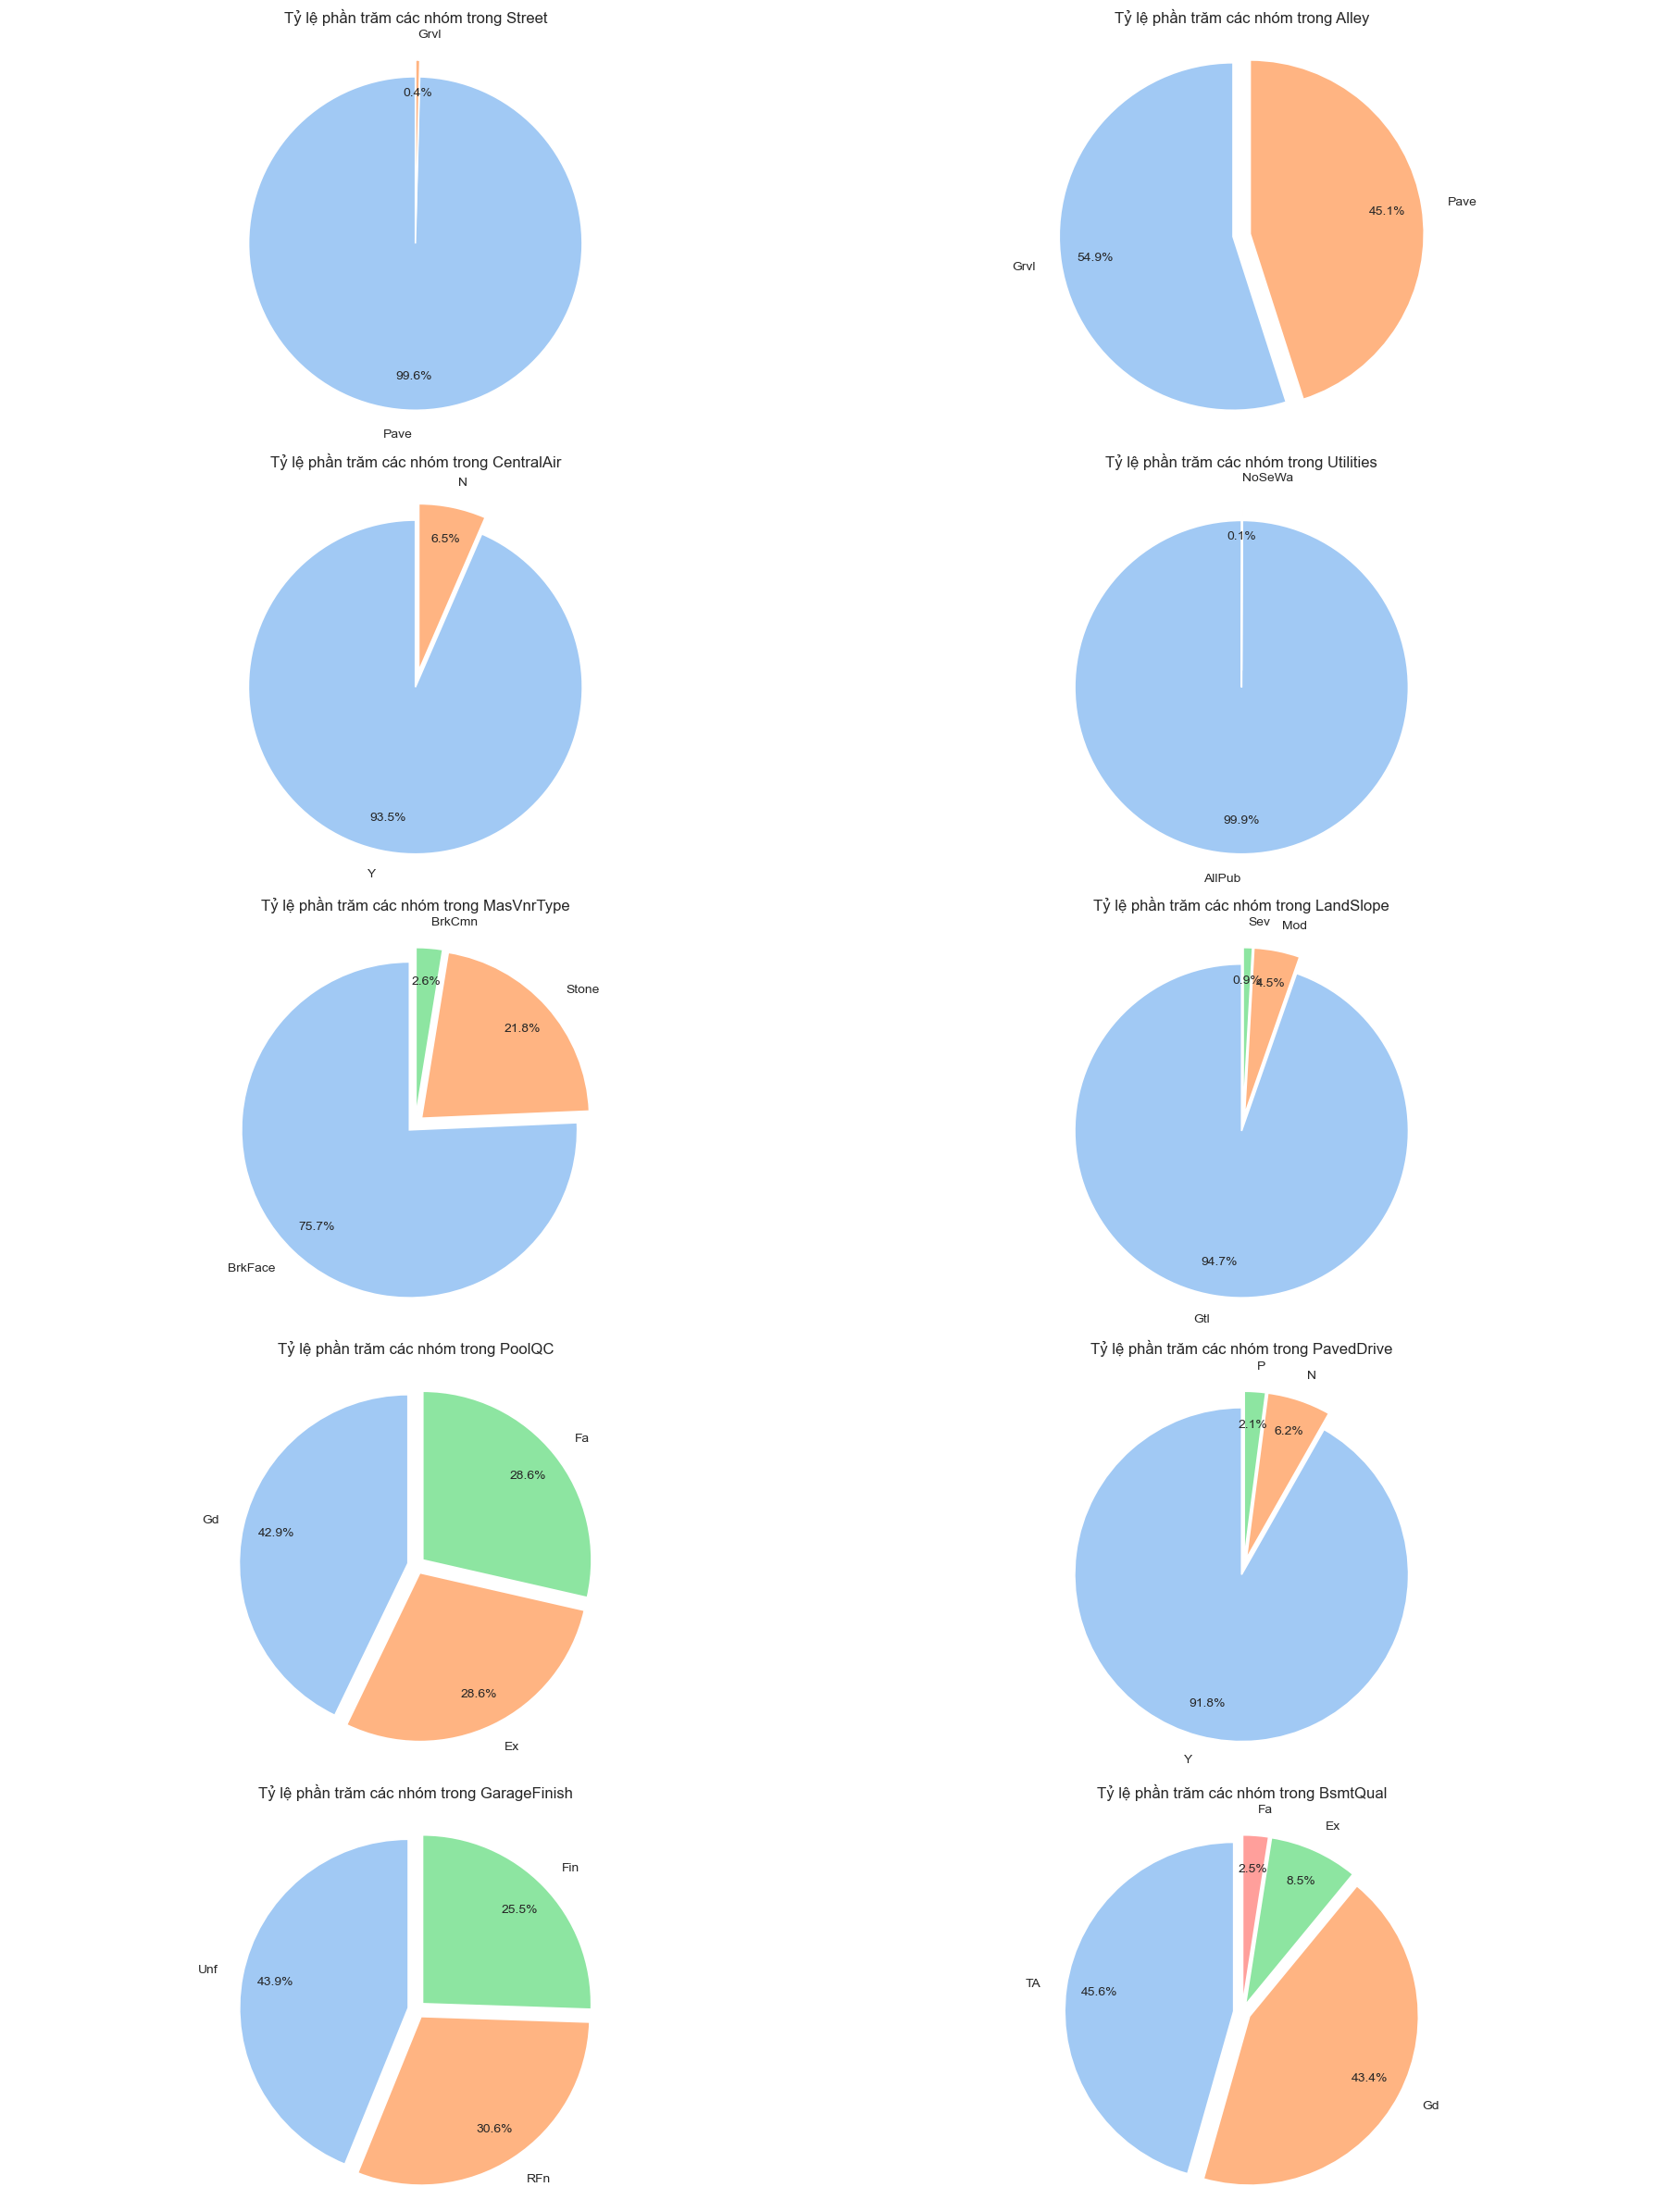

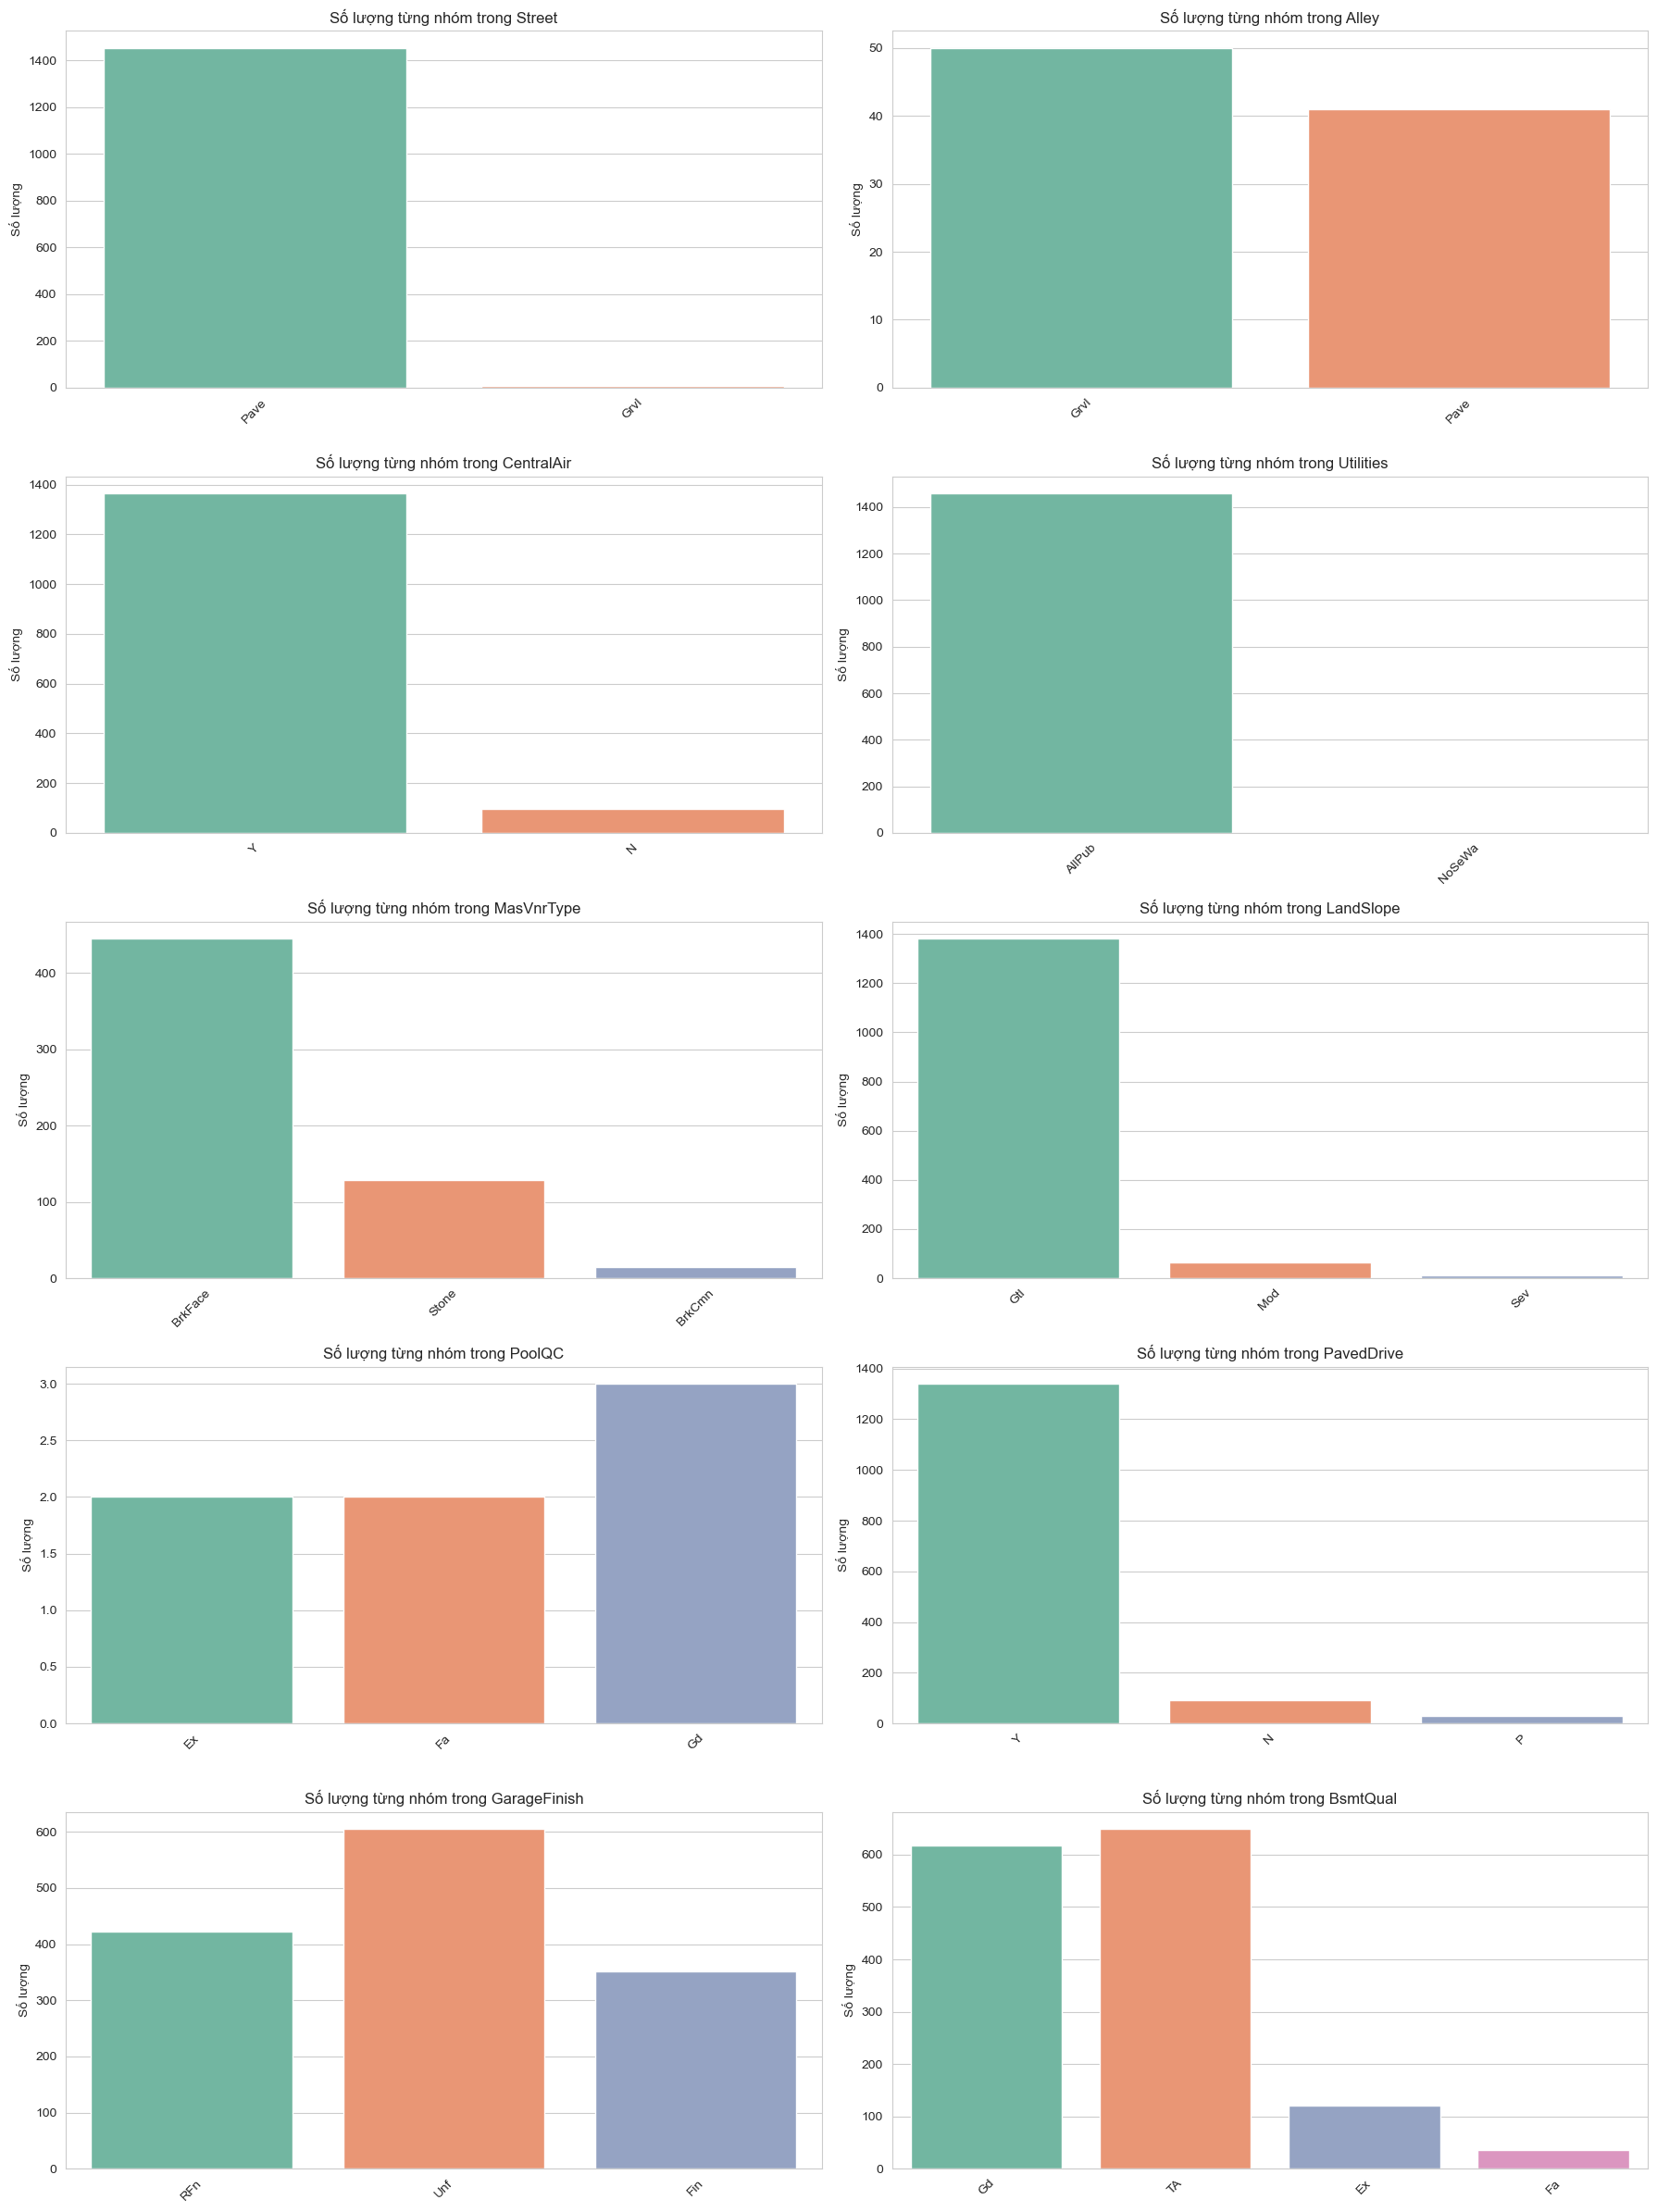

In [6]:
# 5.3. Trực quan hóa top 10 feature tương quan và phân loại categorical

num_cols_all = train.select_dtypes(include=[np.number]).columns.tolist()
corr = train[num_cols_all].corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)

# Lấy top 10 numeric có tương quan mạnh nhất với SalePrice
top_corr = corr.index[1:11]
print("Top 10 feature numeric tương quan mạnh nhất với SalePrice:")
display(top_corr)

# Biểu đồ phân phối
fig, axes = plt.subplots(5, 2, figsize=(12, 18))
axes = axes.flatten()

for i, col in enumerate(top_corr):
    sns.histplot(train[col], kde=True, color="skyblue", ax=axes[i])
    axes[i].set_title(f"Phân phối của {col}")
plt.tight_layout()
plt.show()

# Phân tích biến categorical
cat_cols_all = train.select_dtypes(include=["object"]).columns.tolist()

# Hiển thị số lượng giá trị duy nhất của các biến categorical
cat_counts = train[cat_cols_all].nunique().sort_values()
top_cat = cat_counts.head(10).index.tolist()

print(f"Top {len(top_cat)} biến phân loại có ít giá trị duy nhất nhất:")
display(top_cat)

# Biểu đồ tròn cho các biến categorical
fig, axes = plt.subplots(5, 2, figsize=(18, 24))
axes = axes.flatten()

for i, col in enumerate(top_cat):
    value_counts = train[col].value_counts()
    labels = value_counts.index
    sizes = value_counts.values

    # Làm nổi từng phần
    explode = [0.05] * len(labels)

    wedges, texts, autotexts = axes[i].pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("pastel", len(labels)),
        explode=explode,
        wedgeprops={"edgecolor": "white", "linewidth": 1.2},
        textprops={"fontsize": 10},
        labeldistance=1.15,
        pctdistance=0.8
    )

    axes[i].axis("equal")
    axes[i].set_title(f"Tỷ lệ phần trăm các nhóm trong {col}", fontsize=12, pad=15)

plt.tight_layout()
plt.show()


# Biểu đồ cột cho các biến categorical
fig, axes = plt.subplots(5, 2, figsize=(18, 24))
axes = axes.flatten()

for i, col in enumerate(top_cat):
    sns.countplot(
        data=train,
        x=col,
        hue=col,
        palette="Set2",
        legend=False,
        ax=axes[i]
    )
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].set_title(f"Số lượng từng nhóm trong {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Số lượng")

plt.tight_layout()
plt.show()

In [7]:
# 6. Feature engineering cơ bản
def add_features(df):
    df = df.copy()
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["TotalBath"] = df["FullBath"] + 0.5*df["HalfBath"] + df["BsmtFullBath"] + 0.5*df["BsmtHalfBath"]
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    return df

train = add_features(train)
test  = add_features(test)
display(train[["TotalSF","TotalBath","HouseAge","RemodAge"]].head())


,TotalSF,TotalBath,HouseAge,RemodAge
0,2566,3.5,5,5
1,2524,2.5,31,31
2,2706,3.5,7,6
3,2473,2.0,91,36
4,3343,3.5,8,8


In [8]:
# 7. Xác định cột và Preprocessor 
all_data = pd.concat([train.drop(columns=["SalePrice","SalePrice_log"]), test], axis=0, ignore_index=True)
num_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = all_data.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["Id"]]

# Numeric: median + scale
num_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
])
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

print("\nNumeric columns:")
print(num_cols)

print("\nCategorical columns:")
print(cat_cols)

Numeric: 40 | Categorical: 43

Numeric columns:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'TotalBath', 'HouseAge', 'RemodAge']

Categorical columns:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Central

In [9]:
# 8. Split (target = log)
X = train.drop(columns=["SalePrice", "SalePrice_log"])
y = train["SalePrice_log"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(X_train.shape, X_valid.shape)


(1168, 84) (292, 84)


In [10]:
# 9. Ridge
ridge_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"model__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05]}
gs_ridge = GridSearchCV(ridge_pipe, grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=N_JOBS)

gs_ridge.fit(X_train, y_train)
pred_ridge_log = gs_ridge.predict(X_valid)
ev_ridge = eval_on_logscale(pred_ridge_log, y_valid)
ev_ridge

{'rmse_log': 0.1274482147720078,
 'rmse': 22756.614139531015,
 'r2_log': 0.9129577118079392}

In [11]:
# 10. Random Forest
rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=700,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        max_features=0.8,
        min_samples_leaf=1,
        min_samples_split=2,
        bootstrap=True
    ))
])

rf_pipe.fit(X_train, y_train)
pred_rf_log = rf_pipe.predict(X_valid)
ev_rf = eval_on_logscale(pred_rf_log, y_valid)
ev_rf

{'rmse_log': 0.14497867663647354,
 'rmse': 29936.507528441714,
 'r2_log': 0.8873656002886712}

In [12]:
# 11. XGBoost 
prep_fit = preprocessor.fit(X_train)
Xtr = prep_fit.transform(X_train)
Xva = prep_fit.transform(X_valid)

xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

xgb_base.fit(
    Xtr, y_train,
    eval_set=[(Xva, y_valid)],
    verbose=50
)

pred_xgb_log = xgb_base.predict(Xva)
ev_xgb = eval_on_logscale(pred_xgb_log, y_valid)
ev_xgb

[0]	validation_0-rmse:0.41738
[50]	validation_0-rmse:0.15667
[100]	validation_0-rmse:0.13595
[150]	validation_0-rmse:0.13212
[200]	validation_0-rmse:0.13168
[250]	validation_0-rmse:0.12997
[300]	validation_0-rmse:0.12953
[350]	validation_0-rmse:0.12986
[400]	validation_0-rmse:0.12993
[450]	validation_0-rmse:0.12964
[500]	validation_0-rmse:0.12966
[550]	validation_0-rmse:0.12949
[600]	validation_0-rmse:0.12946
[650]	validation_0-rmse:0.12964
[700]	validation_0-rmse:0.12960
[750]	validation_0-rmse:0.12959
[800]	validation_0-rmse:0.12950
[850]	validation_0-rmse:0.12964
[900]	validation_0-rmse:0.12974
[950]	validation_0-rmse:0.12973
[999]	validation_0-rmse:0.12974


{'rmse_log': 0.1297362096555175,
 'rmse': 25111.535309436516,
 'r2_log': 0.9098044320806427}

In [13]:
# # Lưu model
# import joblib

# xgb_pipe = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", xgb_base)
# ])

# joblib.dump(xgb_pipe, "house_price_xgb.joblib")
# print("Đã lưu model vào house_price_xgb.joblib")

In [14]:
# 12. So sánh kết quả
res = pd.DataFrame([
    {"Model":"Ridge",        **ev_ridge},
    {"Model":"RandomForest", **ev_rf},
    {"Model":"XGBoost",      **ev_xgb},
]).sort_values("rmse")
display(res.reset_index(drop=True))


,Model,rmse_log,rmse,r2_log
0,Ridge,0.127448,22756.614140,0.912958
1,XGBoost,0.129736,25111.535309,0.909804
2,RandomForest,0.144979,29936.507528,0.887366


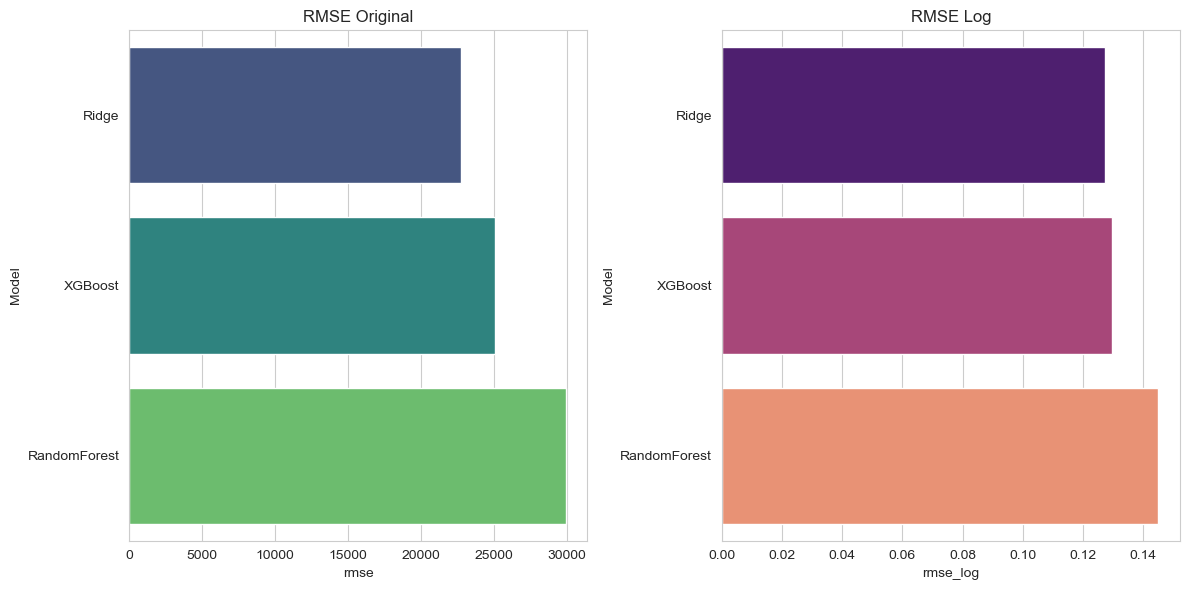

In [15]:
# 13. Biểu đồ so sánh RMSE các mô hình

res_plot = res.sort_values("rmse", ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(data=res_plot, x="rmse", y="Model", hue="Model",
            ax=axes[0], palette="viridis", legend=False)
axes[0].set_title("RMSE Original")

sns.barplot(data=res_plot, x="rmse_log", y="Model", hue="Model",
            ax=axes[1], palette="magma", legend=False)
axes[1].set_title("RMSE Log")

plt.tight_layout()
plt.show()


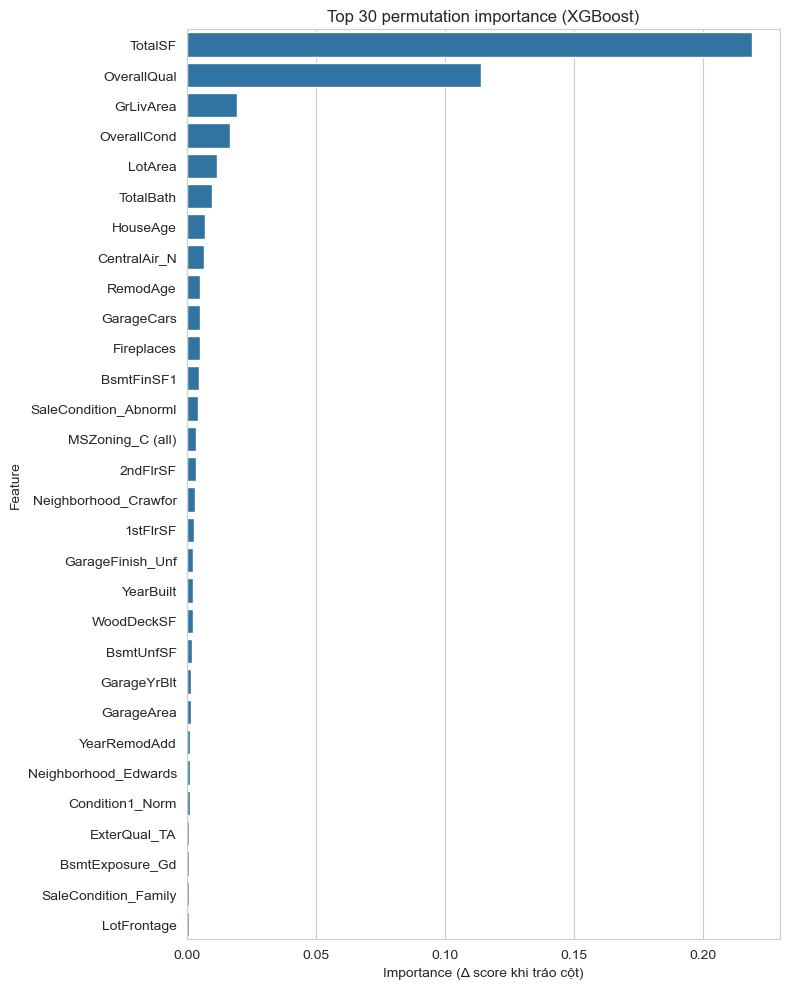

In [16]:
# 14. Permutation Importance (XGBoost)

# Dùng preprocessor đã fit cho XGBoost
Xva_trans = prep_fit.transform(X_valid)

# chuyển dense nếu là sparse
if hasattr(Xva_trans, "toarray"):
    Xva_use = Xva_trans.toarray()
else:
    Xva_use = Xva_trans

# Model XGBoost đã fit
xgb_fitted = xgb_base

# Permutation importance
r = permutation_importance(
    xgb_fitted, Xva_use, y_valid,
    n_repeats=5, random_state=RANDOM_STATE, n_jobs=N_JOBS
)

# Tên feature theo đúng thứ tự cột sau ColumnTransformer (num trước, rồi cat)
cat_names = prep_fit.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
feat_names = list(num_cols) + list(cat_names)

# Top 30
imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x=imp.values, y=imp.index)
plt.title("Top 30 permutation importance (XGBoost)")
plt.xlabel("Importance (Δ score khi tráo cột)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [17]:
# 15. Dự đoán test set

# Tạo transform cho toàn bộ train data trước khi fit final model
X_full = pd.concat([X_train, X_valid], axis=0)
y_full = pd.concat([y_train, y_valid], axis=0)

# Fit preprocessor trên toàn bộ X_full
preprocessor_full = preprocessor.fit(X_full)
X_full_p = preprocessor_full.transform(X_full)
X_test_p = preprocessor_full.transform(test)

final_model = ridge_pipe.named_steps["model"]  # chọn Ridge

final_model.fit(X_full_p, y_full)

# Dự đoán (log scale) -> back to original
test_preds_log = final_model.predict(X_test_p)
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': test_preds})
submission.to_csv('submission.csv', index=False)
print("Saved submission.csv, shape:", submission.shape)
submission.head()


Saved submission.csv, shape: (1459, 2)


,Id,SalePrice
0,1461,118565.019417
1,1462,146653.155662
2,1463,176475.443597
3,1464,195656.864620
4,1465,200155.339103
